## Objective
* To perform Sentiment Analysis on Game of Thrones, based on speculations & reactions from US twitter users.

## Tools & Technologies used
* Python
* NLTK libraries
* Spacy
* Wordcloud libraries
* Scikit-learn (Topic Modelling)
* VADER (Sentiment Analysis)

## Project Workflow
* Data Acquisition
* Explore Data
* Prepare and Clean Data
* Data Analysis
* Visualize results

#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import re
import random
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.corpus.reader.wordnet import NOUN
from nltk.corpus.reader.wordnet import VERB
from nltk.corpus.reader.wordnet import ADJ
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from spacy.lang.en import English
from sklearn.decomposition import LatentDirichletAllocation
from os import path, getcwd
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim import corpora
import pyLDAvis.gensim

%matplotlib inline
pd.set_option('display.max_columns', 100)

In [2]:
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package words to /Users/eshank/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /Users/eshank/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/eshank/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
stop_words = set(stopwords.words("english"))
worddict = set(nltk.corpus.words.words())
lemmatizer = WordNetLemmatizer()
analyser = SentimentIntensityAnalyzer()
stemmer = PorterStemmer()

## Preliminary Dataset Investigation

#### Load the dataset

In [4]:
df_got = pd.read_csv('gotTwitter.csv')

/Users/eshank/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Check number of rows and columns in dataset

In [5]:
df_got.shape

(760660, 88)

* Dataset has 760660 rows and 88 columns

In [6]:
df_got.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favorite_count,retweet_count,hashtags,symbols,urls_url,urls_t.co,urls_expanded_url,media_url,media_t.co,media_expanded_url,media_type,ext_media_url,ext_media_t.co,ext_media_expanded_url,ext_media_type,mentions_user_id,mentions_screen_name,lang,quoted_status_id,quoted_text,quoted_created_at,quoted_source,quoted_favorite_count,quoted_retweet_count,quoted_user_id,quoted_screen_name,quoted_name,quoted_followers_count,quoted_friends_count,quoted_statuses_count,quoted_location,quoted_description,quoted_verified,retweet_status_id,retweet_text,retweet_created_at,retweet_source,retweet_favorite_count,retweet_retweet_count,retweet_user_id,retweet_screen_name,retweet_name,retweet_followers_count,retweet_friends_count,retweet_statuses_count,retweet_location,retweet_description,retweet_verified,place_url,place_name,place_full_name,place_type,country,country_code,geo_coords,coords_coords,bbox_coords,status_url,name,location,description,url,protected,followers_count,friends_count,listed_count,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
0,x51554079,x1118417386150014976,2019-04-17 07:34:18,moevazquez,👍 on @YouTube: GAME OF THRONES 8x01 Breakdown!...,IFTTT,99,NaN,NaN,NaN,False,False,0,0,NaN,NaN,youtu.be/8YuXkI1xucc,https://t.co/Ig8QyNPtkL,https://youtu.be/8YuXkI1xucc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x10228272,YouTube,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/moevazquez/status/11184173...,lagoon monster,mexico city,darkness comes alive ...,https://t.co/UtWjeVMUCT,False,4497,4984,48,206478,36131,2009-06-27 20:58:25,False,https://t.co/UtWjeVMUCT,https://www.facebook.com/moisesvo,es,https://pbs.twimg.com/profile_banners/51554079...,http://abs.twimg.com/images/themes/theme18/bg.gif,http://pbs.twimg.com/profile_images/9788848932...
1,x51554079,x1117994592136249344,2019-04-16 03:34:16,moevazquez,👍 on @YouTube: Ups and Downs From Game Of Thro...,IFTTT,77,NaN,NaN,NaN,False,False,0,0,NaN,NaN,youtu.be/gAR3gbNXgf4,https://t.co/CZndqySpWS,https://youtu.be/gAR3gbNXgf4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x10228272,YouTube,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/moevazquez/status/11179945...,lagoon monster,mexico city,darkness comes alive ...,https://t.co/UtWjeVMUCT,False,4497,4984,48,206478,36131,2009-06-27 20:58:25,False,https://t.co/UtWjeVMUCT,https://www.facebook.com/moisesvo,es,https://pbs.twimg.com/profile_banners/51554079...,http://abs.twimg.com/images/themes/theme18/bg.gif,http://pbs.twimg.com/profile_images/9788848932...
2,x51554079,x1117987511391981568,2019-04-16 03:06:08,moevazquez,Liked on YouTube: Ups and Downs From Game Of T...,IFTTT,80,NaN,NaN,NaN,False,False,0,0,NaN,NaN,youtu.be/gAR3gbNXgf4,https://t.co/CZndqySpWS,https://youtu.be/gAR3gbNXgf4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/moevazquez/status/11179875...,lagoon monster,mexico city,darkness comes alive ...,https://t.co/UtWjeVMUCT,False,4497,4984,48,206478,36131,2009-06-27 20:58:25,False,https://t.co/UtWjeVMUCT,https://www.facebook.com/moisesvo,es,https://pbs.twimg.com/profile_banners/51554079...,http://abs.twimg.com/images/themes/theme18/bg.gif,http://pbs.twimg.com/profile_images/9788848932...
3,x51554079,x1118410676475760640,2019-04-17 07:07:38,moevazquez,Liked on YouTube: GAME OF THRONES 8x01 Breakdo...,IFTT

#### Use relevant columns - 
* user_id
* created_at
* source
* text
* display_text_width
* geo_coords

In [7]:
# read necessary columns for analysis
df_got = pd.read_csv('gotTwitter.csv', 
                     usecols=['user_id', 'created_at', 'source', 'text', 'display_text_width', 'geo_coords'])

## Data Cleaning & Preparation

In [8]:
# rename columns
df_got = df_got.rename(columns={'text':'raw_tweets', 'display_text_width':'character_length'})

In [9]:
# split created_at into date for compound score
df_got['Timeline'] = pd.to_datetime(df_got['created_at']).dt.date

# change Timeline into datetime format for wordcloud
df_got['Dates'] = pd.to_datetime(df_got['Timeline'])

In [10]:
# split geo_coords column to get latitude & longitude
x = df_got['geo_coords'].str.split()

In [11]:
# get latitude
latitude = [x[i][0] for i in range(len(x))]

In [12]:
# get longitude
longitude = [x[i][1] for i in range(len(x))]

In [13]:
X_pd = pd.DataFrame(data=latitude, columns=['a'])
Y_pd = pd.DataFrame(data=longitude, columns=['b'])

In [14]:
# replace 'NA' value in dataframe with '0'
X_pd = X_pd.replace('NA', 0)
Y_pd = Y_pd.replace('NA', 0)

In [15]:
# convert the dataframe value to float
X_pd = X_pd.astype(float)
Y_pd = Y_pd.astype(float)

In [16]:
# copy the dataframe values to latitude & longitude column
df_got['latitude'] = X_pd['a']
df_got['longitude'] = Y_pd['b']

In [17]:
df_got.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760660 entries, 0 to 760659
Data columns (total 10 columns):
user_id             760660 non-null object
created_at          760660 non-null object
raw_tweets          760660 non-null object
source              760660 non-null object
character_length    760660 non-null int64
geo_coords          760660 non-null object
Timeline            760660 non-null object
Dates               760660 non-null datetime64[ns]
latitude            760660 non-null float64
longitude           760660 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 58.0+ MB


In [18]:
df_got.head()

,user_id,created_at,raw_tweets,source,character_length,geo_coords,Timeline,Dates,latitude,longitude
0,x51554079,2019-04-17 07:34:18,👍 on @YouTube: GAME OF THRONES 8x01 Breakdown!...,IFTTT,99,NA NA,2019-04-17,2019-04-17,0.0,0.0
1,x51554079,2019-04-16 03:34:16,👍 on @YouTube: Ups and Downs From Game Of Thro...,IFTTT,77,NA NA,2019-04-16,2019-04-16,0.0,0.0
2,x51554079,2019-04-16 03:06:08,Liked on YouTube: Ups and Downs From Game Of T...,IFTTT,80,NA NA,2019-04-16,2019-04-16,0.0,0.0
3,x51554079,2019-04-17 07:07:38,Liked on YouTube: GAME OF THRONES 8x01 Breakdo...,IFTTT,102,NA NA,2019-04-17,2019-04-17,0.0,0.0
4,x770111944187580416,2019-04-17 07:34:09,@MrLegenDarius unpopular opinion: game of thro...,Twitter for iPhone,42,NA NA,2019-04-17,2019-04-17,0.0,0.0


## Data Preprocessing

In [19]:
# converts given text into lowercase
def to_lowercase(text):
    wordset = text.lower()
    return wordset

In [20]:
# removes hyperlinks from the text
def remove_links(text):
    wordset = re.sub(r"http\S+", "", text)
    return wordset

In [21]:
# removes '@' from the text
def remove_symbols(text):
    wordset = re.sub('@[^\s]+','',text)
    return wordset

<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<ipython-input-21-bea6fa71931d>:3: DeprecationWarning: invalid escape sequence \s
  wordset = re.sub('@[^\s]+','',text)


In [22]:
# removes punctuations from the text
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation) 
    return text.translate(translator)

In [23]:
# removes numbers from the text
def remove_numbers(text):
    wordset = re.sub(r'\d+', '', text)
    return wordset

In [24]:
# removes stopwords from the text
def remove_stopwords(text):
    word_tokens = word_tokenize(text) 
    wordset = [word for word in word_tokens if word not in stop_words] 
    return wordset 

In [25]:
# normalizes the given input
def normalize(words):
    words = to_lowercase(words)
    words = remove_links(words)
    words = remove_symbols(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    return words

In [26]:
# performs stemming operation for the given input
def stem_words(text):
    wordset = [stemmer.stem(word) for word in text]
    return wordset 

In [27]:
# performs lemmatization operation for the given input
def lemmatize_words(text):
    wordset_n = set(lemmatizer.lemmatize(w, NOUN) for w in text)
    wordset_v = set(lemmatizer.lemmatize(w, VERB) for w in wordset_n)
    wordset = set(lemmatizer.lemmatize(w, ADJ) for w in wordset_v)
    wordset = wordset & worddict
    return wordset 

In [28]:
# converts list to string
def list_to_string(text):
    return  " ".join(text) 

#### Apply preprocessing functions to the tweets column

In [29]:
df_got['p_tweets'] = df_got['raw_tweets'].apply(to_lowercase)

In [30]:
df_got['p_tweets'] = df_got['p_tweets'].apply(remove_links)

In [31]:
df_got['p_tweets'] = df_got['p_tweets'].apply(remove_symbols)

In [32]:
df_got['p_tweets'] = df_got['p_tweets'].apply(remove_numbers)

In [33]:
df_got['p_tweets'] = df_got['p_tweets'].apply(remove_punctuation)

In [34]:
df_got['p_tweets']

0         👍 on  game of thrones x breakdown night king s...
1                👍 on  ups and downs from game of thrones  
2         liked on youtube ups and downs from game of th...
3         liked on youtube game of thrones x breakdown n...
4                 unpopular opinion game of thrones edition
5         reddit is bursting with game of thrones theori...
6         reddit is bursting with game of thrones theori...
7          game of thrones season  reddit theories that ...
8         what reddits game of thrones fans really thoug...
9         game of thrones star john bradley explains spo...
10        game of thrones star john bradley explains spo...
11        dark fantasy comic reaver arrives in time for ...
12                          how game of thrones should end 
13        game of thrones cast works in call center for ...
14               how do you think the show is going to end 
15               how do you think the show is going to end 
16        correctly guess ending of game

In [35]:
df_got['text'] = df_got['p_tweets'].apply(remove_stopwords)

In [36]:
df_got['text'] = df_got['text'].apply(stem_words)

In [37]:
df_got['text'] = df_got['text'].apply(lemmatize_words)

In [38]:
df_got['text'] = df_got['text'].apply(list_to_string)

In [39]:
df_got['text']

0         x explain game night king symbol throne breakdown
1                                       down up throne game
2                                  like game up down throne
3         x like explain game night king symbol throne b...
4                        unpopular opinion game edit throne
5                              stark game burst bran throne
6                              stark game burst bran throne
7                             season rock game world throne
8                season today game think fan premier throne
9            explain game comic star premier spoiler throne
10           explain game comic star premier spoiler throne
11              dark time game comic reaver withdraw throne
12                                          game end throne
13                  phone call game center cast work throne
14                                        show think go end
15                                        show think go end
16                          game could g

#### Get compound score & labels of tweets using VADER

In [40]:
# get compound score from the tweets
def get_polarity_score(text):
    score = analyser.polarity_scores(text)
    return score['compound']

In [41]:
# store the compound score in new column
df_got['tweets_compound_score'] = df_got['p_tweets'].apply(get_polarity_score)

#### Get text data of wordcloud for each episode

In [42]:
# Winterfell 2019-04-14
def winterfell(x):
    epi_1_mask = df_got[(df_got['Dates'] >= '2019-04-14') & (df_got['Dates'] < '2019-04-20')]
    return ' '.join(epi_1_mask['text'])

* generates wordcloud for Episode 1: Winterfell

In [43]:
# A knight of Seven Kingdoms 2019-04-21
def seven_kingdoms(x):
    epi_2_mask = df_got[(df_got['Dates'] >= '2019-04-21') & (df_got['Dates'] < '2019-04-27')]
    return ' '.join(epi_2_mask['text'])

* generates wordcloud for Episode 2: A knight of Seven Kingdoms

In [44]:
# The Long Night 2019-04-28
def long_knight(x):
    epi_3_mask = df_got[(df_got['Dates'] >= '2019-04-28') & (df_got['Dates'] < '2019-05-04')]
    return ' '.join(epi_3_mask['text'])

* generates wordcloud for Episode 3: The Long Night

In [45]:
# The Last of Starks 2019-05-05
def last_of_starks(x):
    epi_4_mask = df_got[(df_got['Dates'] >= '2019-05-05') & (df_got['Dates'] < '2019-05-11')]
    return ' '.join(epi_4_mask['text'])

* generates wordcloud for Episode 4: The Last of Starks

In [46]:
# The Bells 2019-05-12
def the_bells(x):
    epi_5_mask = df_got[(df_got['Dates'] >= '2019-05-12') & (df_got['Dates'] < '2019-05-18')]
    return ' '.join(epi_5_mask['text'])

* generates wordcloud for Episode 5: The Bells

In [47]:
# The Iron Throne april 19th
def iron_throne(x):
    epi_6_mask = df_got[(df_got['Dates'] >= '2019-05-19')]
    return ' '.join(epi_6_mask['text'])

* generates wordcloud for Episode 6: The Iron Throne

In [48]:
# convert/save dataset to csv
df = pd.DataFrame(df_got)
df.to_csv('got8.csv', encoding='utf-8', index=False)

## Exploratory Data Analysis

In [49]:
df_got.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760660 entries, 0 to 760659
Data columns (total 13 columns):
user_id                  760660 non-null object
created_at               760660 non-null object
raw_tweets               760660 non-null object
source                   760660 non-null object
character_length         760660 non-null int64
geo_coords               760660 non-null object
Timeline                 760660 non-null object
Dates                    760660 non-null datetime64[ns]
latitude                 760660 non-null float64
longitude                760660 non-null float64
p_tweets                 760660 non-null object
text                     760660 non-null object
tweets_compound_score    760660 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(8)
memory usage: 75.4+ MB


In [50]:
df_got.describe()

,character_length,latitude,longitude,tweets_compound_score
count,760660.000000,760660.000000,760660.000000,760660.000000
mean,112.319532,0.110574,-0.269721,0.053009
std,63.094604,2.056793,5.049371,0.426940
min,15.000000,0.000000,-123.230000,-0.995500
25%,67.000000,0.000000,0.000000,-0.177900
50%,99.000000,0.000000,0.000000,0.000000
75%,142.000000,0.000000,0.000000,0.381800
max,1024.000000,56.000000,0.000000,0.998700


In [51]:
df_got.head()

,user_id,created_at,raw_tweets,source,character_length,geo_coords,Timeline,Dates,latitude,longitude,p_tweets,text,tweets_compound_score
0,x51554079,2019-04-17 07:34:18,👍 on @YouTube: GAME OF THRONES 8x01 Breakdown!...,IFTTT,99,NA NA,2019-04-17,2019-04-17,0.0,0.0,👍 on game of thrones x breakdown night king s...,x explain game night king symbol throne breakdown,0.0000
1,x51554079,2019-04-16 03:34:16,👍 on @YouTube: Ups and Downs From Game Of Thro...,IFTTT,77,NA NA,2019-04-16,2019-04-16,0.0,0.0,👍 on ups and downs from game of thrones,down up throne game,0.0000
2,x51554079,2019-04-16 03:06:08,Liked on YouTube: Ups and Downs From Game Of T...,IFTTT,80,NA NA,2019-04-16,2019-04-16,0.0,0.0,liked on youtube ups and downs from game of th...,like game up down throne,0.4215
3,x51554079,2019-04-17 07:07:38,Liked on YouTube: GAME OF THRONES 8x01 Breakdo...,IFTTT,102,NA NA,2019-04-17,2019-04-17,0.0,0.0,liked on youtube game of thrones x breakdown n...,x like explain game night king symbol throne b...,0.4215
4,x770111944187580416,2019-04-17 07:34:09,@MrLegenDarius unpopular opinion: game of thro...,Twitter for iPhone,42,NA NA,2019-04-17,2019-04-17,0.0,0.0,unpopular opinion game of thrones edition,unpopular opinion game edit throne,0.0000


In [52]:
pos = df_got[df_got['tweets_compound_score'] > 0.0]
pos_per = (len(pos)/len(df_got)) * 100
print('Postive Percent ', pos_per)

Postive Percent  38.127678594904424


In [53]:
neu = df_got[df_got['tweets_compound_score'] == 0.0]
neu_per = (len(neu)/len(df_got)) * 100
print('Neutral Percent ', neu_per)

Neutral Percent  33.291483711513685


In [54]:
neg = df_got[df_got['tweets_compound_score'] < 0.0]
neg_per = (len(neg)/len(df_got)) * 100
print('Negtive Percent ', neg_per)

Negtive Percent  28.58083769358189


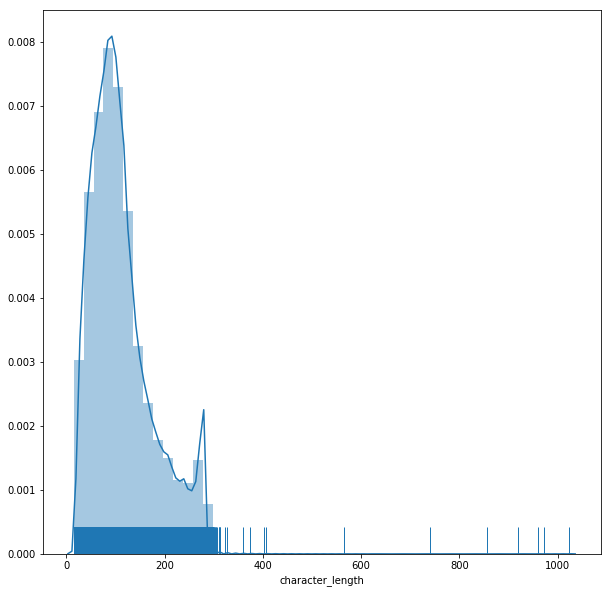

In [55]:
plt.figure(figsize=[10, 10])
chr_length = df_got['character_length']
sns.distplot(chr_length, rug=True);

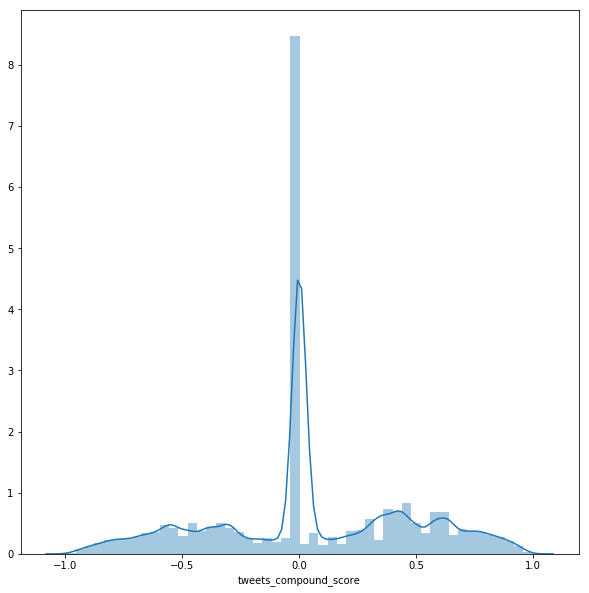

In [56]:
plt.figure(figsize=[10, 10])
cpd_score = df_got['tweets_compound_score']
sns.distplot(cpd_score);

## Topic Modelling for Episode 5

In [57]:
episode_5 = df_got[(df_got['Dates'] >= '2019-05-12') & (df_got['Dates'] < '2019-05-19')]
episode_5

,user_id,created_at,raw_tweets,source,character_length,geo_coords,Timeline,Dates,latitude,longitude,p_tweets,text,tweets_compound_score
487706,x1122289898889912320,2019-05-12 02:59:41,@JosephJMiccolis And what happens on Game of T...,Twitter for Android,36,NA NA,2019-05-12,2019-05-12,0.0,0.0,and what happens on game of thrones,game happen throne,0.0000
487707,x439594110,2019-05-12 02:59:00,I love Game of Thrones but here<U+2019>s my in...,Twitter for iPhone,279,NA NA,2019-05-12,2019-05-12,0.0,0.0,i love game of thrones but hereus my interesti...,game board interest love unless king iron thro...,0.2772
487708,x1016784296,2019-05-12 02:58:56,starting the game of thrones finallllly,Twitter for iPhone,39,NA NA,2019-05-12,2019-05-12,0.0,0.0,starting the game of thrones finallllly,game start throne,0.0000
487709,x502333392,2019-05-12 02:58:42,I need help. I<U+2019>m high and idk if I shou...,Twitter for iPhone,155,NA NA,2019-05-12,2019-05-12,0.0,0.0,i need help ium high and idk if i should watch...,game need want watch show high play throne kin...,0.3528
487710,x164708941,2019-05-12 02:58:11,My mom moved up Mother<U+2019>s Day dinner bec...,Twitter for iPhone,64,NA NA,2019-05-12,2019-05-12,0.0,0.0,my mom moved up motherus day dinner because of...,day game dinner move throne,0.0000
487711,x3111891547,2019-05-12 02:58:00,Love the Game of Thrones,Twitter for iPhone,24,NA NA,2019-05-12,2019-05-12,0.0,0.0,love the game of thrones,game throne love,0.6369
487712,x792252902,2019-05-12 02:57:22,Game of Thrones porn parodies &gt; the HBO show,Twitter Web App,47,NA NA,2019-05-12,2019-05-12,0.0,0.0,game of thrones porn parodies gt the hbo show,show throne game,0.2732
487713,x23339000,2019-05-12 02:57:02,"On Game of Thrones night at Target Field, the ...",TweetDeck,122,NA NA,2019-05-12,2019-05-12,0.0,0.0,on game of thrones night at target field the t...,aria field game tiger target night name throne...,-0.4767
487714,x2708007534,2019-05-12 02:56:49,I'm so glad someone finally put this into word...,Twitter Web App,72,NA NA,2019-05-12,2019-05-12,0.0,0.0,im so glad someone finally put this into words,glad put final word,0.5095
487715,x2172922045,2019-05-12 02:56:11,Pictured: a re-enactment of our social media t...,Buffer,266,NA NA,2019-05-12,2019-05-12,0.0,0.0,pictured a reenactment of our social media tea...,season year social moment make medium premier ...,0.4588


In [58]:
episode_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111332 entries, 487706 to 648692
Data columns (total 13 columns):
user_id                  111332 non-null object
created_at               111332 non-null object
raw_tweets               111332 non-null object
source                   111332 non-null object
character_length         111332 non-null int64
geo_coords               111332 non-null object
Timeline                 111332 non-null object
Dates                    111332 non-null datetime64[ns]
latitude                 111332 non-null float64
longitude                111332 non-null float64
p_tweets                 111332 non-null object
text                     111332 non-null object
tweets_compound_score    111332 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(8)
memory usage: 11.9+ MB


In [59]:
episode_5.head()

,user_id,created_at,raw_tweets,source,character_length,geo_coords,Timeline,Dates,latitude,longitude,p_tweets,text,tweets_compound_score
487706,x1122289898889912320,2019-05-12 02:59:41,@JosephJMiccolis And what happens on Game of T...,Twitter for Android,36,NA NA,2019-05-12,2019-05-12,0.0,0.0,and what happens on game of thrones,game happen throne,0.0000
487707,x439594110,2019-05-12 02:59:00,I love Game of Thrones but here<U+2019>s my in...,Twitter for iPhone,279,NA NA,2019-05-12,2019-05-12,0.0,0.0,i love game of thrones but hereus my interesti...,game board interest love unless king iron thro...,0.2772
487708,x1016784296,2019-05-12 02:58:56,starting the game of thrones finallllly,Twitter for iPhone,39,NA NA,2019-05-12,2019-05-12,0.0,0.0,starting the game of thrones finallllly,game start throne,0.0000
487709,x502333392,2019-05-12 02:58:42,I need help. I<U+2019>m high and idk if I shou...,Twitter for iPhone,155,NA NA,2019-05-12,2019-05-12,0.0,0.0,i need help ium high and idk if i should watch...,game need want watch show high play throne kin...,0.3528
487710,x164708941,2019-05-12 02:58:11,My mom moved up Mother<U+2019>s Day dinner bec...,Twitter for iPhone,64,NA NA,2019-05-12,2019-05-12,0.0,0.0,my mom moved up motherus day dinner because of...,day game dinner move throne,0.0000


In [60]:
text = episode_5['text']
text

487706                                   game happen throne
487707    game board interest love unless king iron thro...
487708                                    game start throne
487709    game need want watch show high play throne kin...
487710                          day game dinner move throne
487711                                     game throne love
487712                                     show throne game
487713    aria field game tiger target night name throne...
487714                                  glad put final word
487715    season year social moment make medium premier ...
487725    late dead mean import fight show look first co...
487747                boston globe game fan cup goof throne
487748                                bucket mani use blood
487749    dragon call game gon there na night tomorrow t...
487750                                 se watch throne game
487751                                       ad throne game
487752    like hour get game straight fe

In [61]:
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [62]:
def get_lemma(word):
    lemma = wordnet.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [63]:
skip_words = ['would', 'could', 'throne', 'season', 'think', 'one', 'watch', 'episode', 'something', 'theory', 'maybe', 'gameofthrones',
             'scene', 'anyone', 'really', 'still', 'anyone', 'already', 'anything', 'never', 'everyone', 'series', 'even', 'SCREEN_NAME',
              'u+2019', 'u+201d', 'u+201c', 'u+2018']

In [64]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token not in skip_words]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [65]:
text_data = []
for line in text:
    tokens = prepare_text_for_lda(line)
    if random.random() > .99:
        text_data.append(tokens)

In [66]:
text_data = [x for x in text_data if x != []]

In [67]:
dictionary = corpora.Dictionary(text_data)

In [68]:
corpus = [dictionary.doc2bow(text) for text in text_data]

In [69]:
NUM_TOPICS = 2
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
#ldamodel.save('model_bells_5.gensim')

In [70]:
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.027*"spoiler" + 0.021*"final" + 0.015*"disappoint" + 0.014*"tonight" + 0.012*"start" + 0.010*"first" + 0.010*"finish" + 0.009*"spoil" + 0.009*"queen" + 0.008*"thank"')
(1, '0.032*"final" + 0.026*"night" + 0.023*"writer" + 0.022*"petit" + 0.021*"write" + 0.016*"thing" + 0.013*"twitter" + 0.012*"happen" + 0.012*"actual" + 0.011*"dragon"')


In [71]:
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_display, 'bells_pyldavis2.html')
#pyLDAvis.display(lda_display)

/Users/eshank/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Visualization

### Sentiment Score

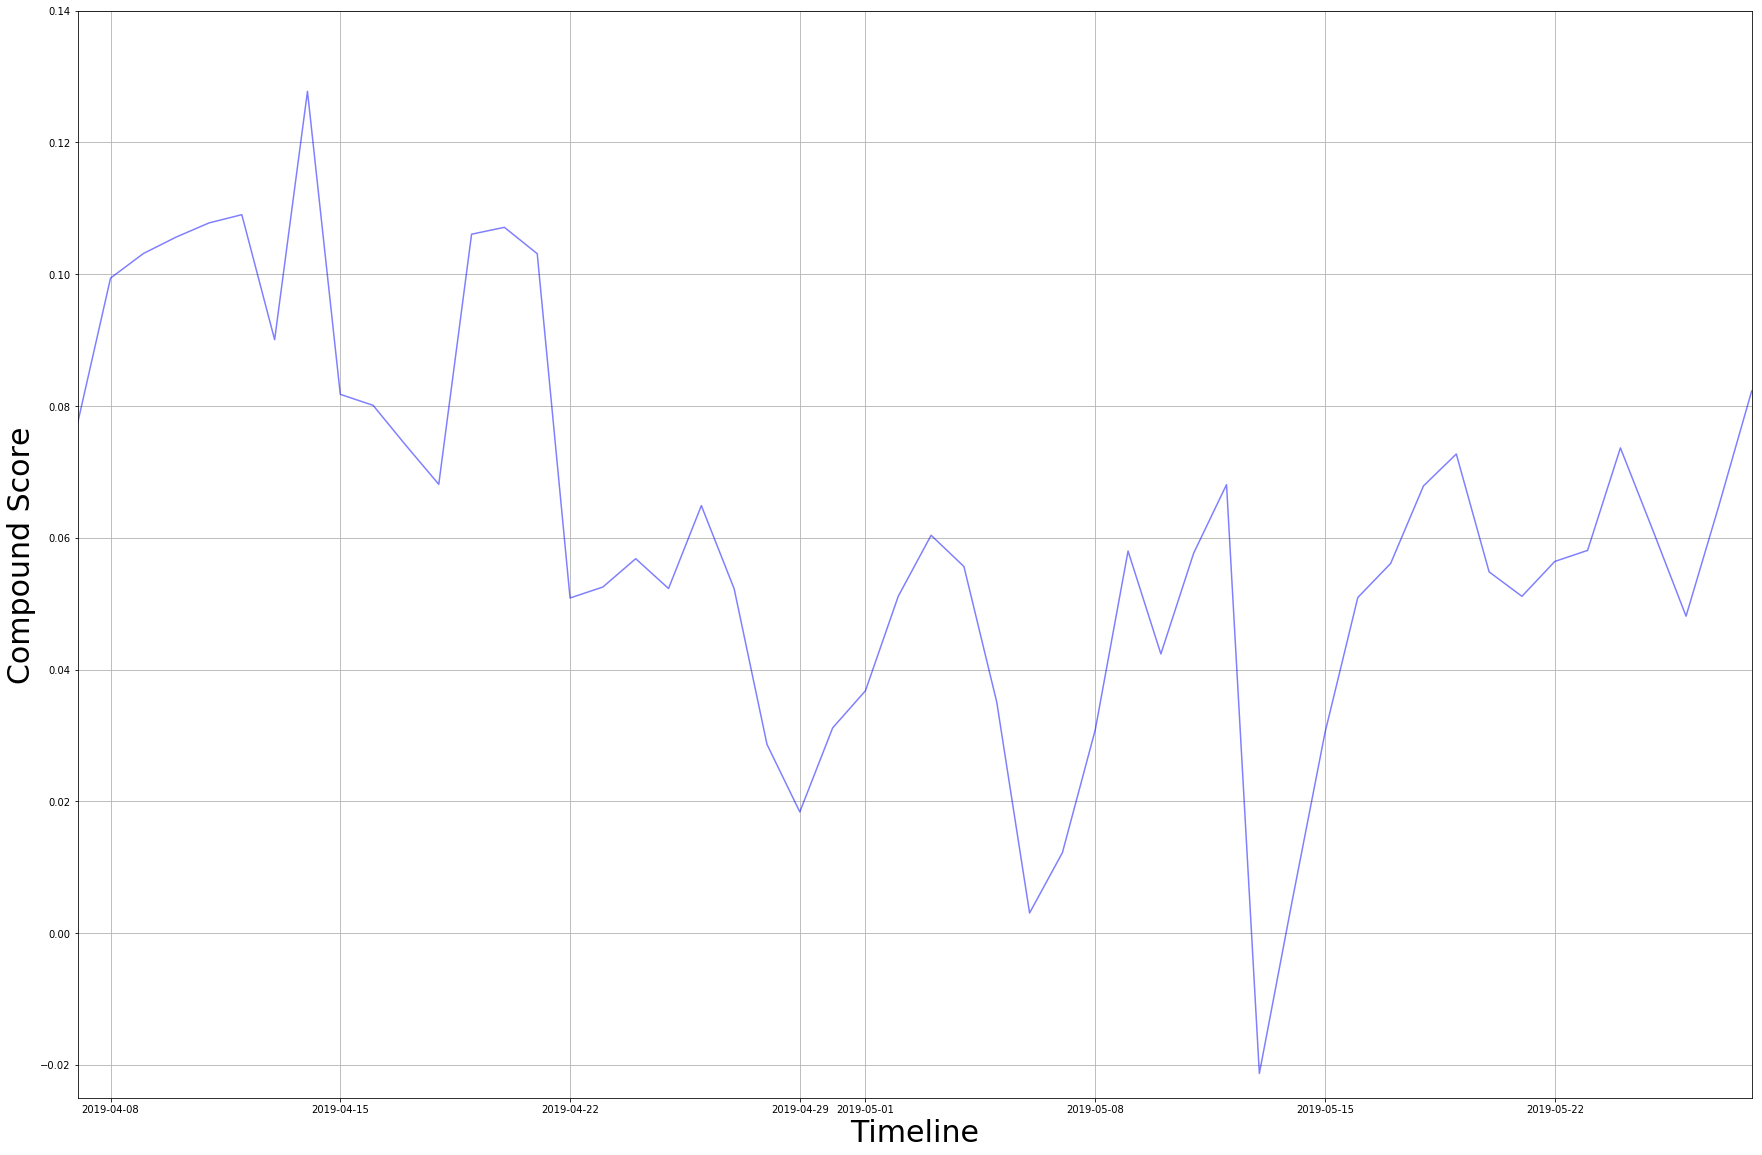

In [72]:
# calculates the compound score by dates
plot_score = df_got.groupby('Timeline')['tweets_compound_score'].mean()

plt.figure(figsize=(30, 20))
plt.ylim(-0.025, 0.14)
plt.xlabel('Timeline', fontsize=30)
plt.ylabel('Compound Score', fontsize=30)
plot_score.plot(kind='line', color='b', alpha=0.5)
plt.grid()
plt.show();

### Winterfell

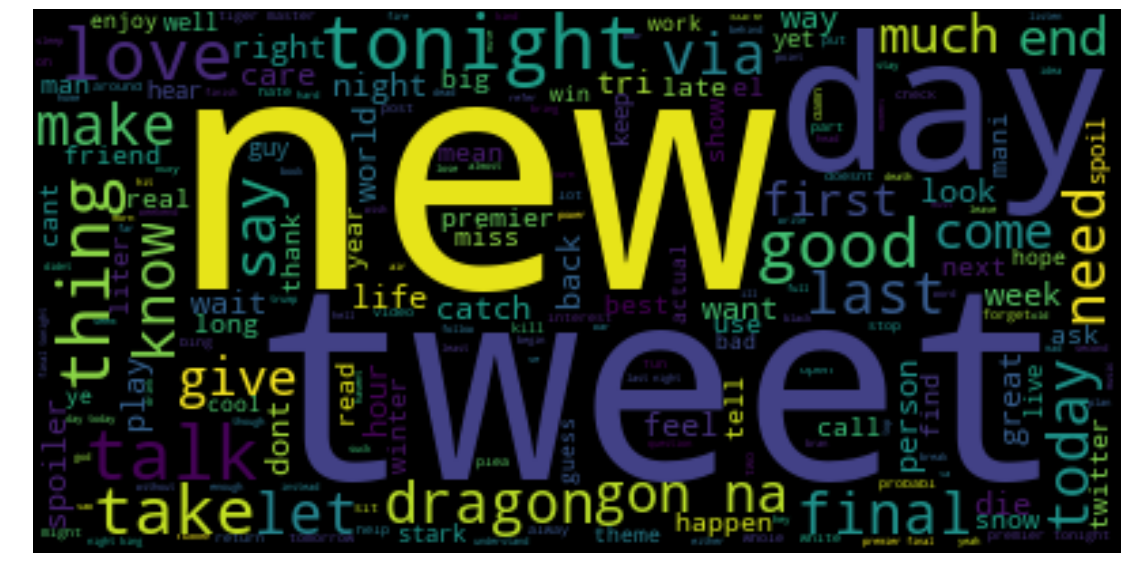

In [73]:
text = winterfell(x)
plt.figure(figsize=(20, 10))
# Create and generate a word cloud image:
stopwords = set(STOPWORDS)
stopwords.update(['throne', 'game', 'go', 'see', 'season', 'think', 'one', 'watch', 'fan', 'time', 'start', 'maybe',
             'scene', 'anyone', 'really', 'still', 'anyone', 'already', 'anything', 'never', 'everyone', 'even'])

wc = WordCloud(stopwords=stopwords, background_color='black')
wc.generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')

plt.axis("off")
plt.show()

### A knight of Seven Kingdoms

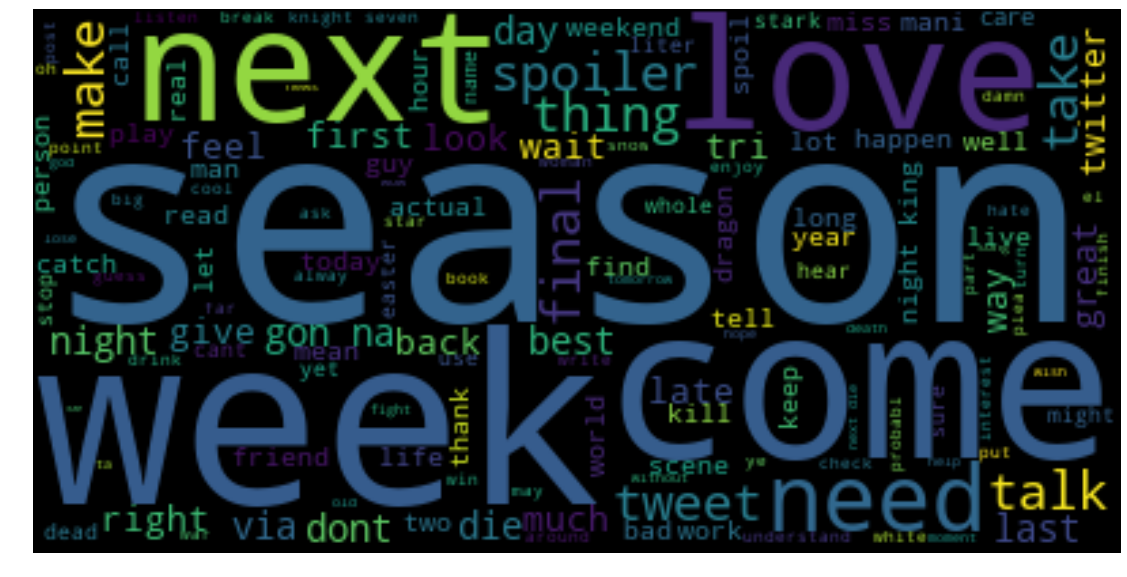

In [74]:
text = seven_kingdoms(x)
plt.figure(figsize=(20, 10))
# Create and generate a word cloud image:
stopwords = set(STOPWORDS)
stopwords.update(['throne', 'game', 'go', 'start', 'show', 'time', 'fan', 'new', 'see', 'know', 'watch', 'one', 'think', 'tonight',
             'say', 'good', 'want', 'still', 'end', 'already', 'anything', 'never', 'everyone', 'even'])

wc = WordCloud(stopwords=stopwords, background_color='black')
wc.generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')

plt.axis("off")
plt.show()

### The Long Night

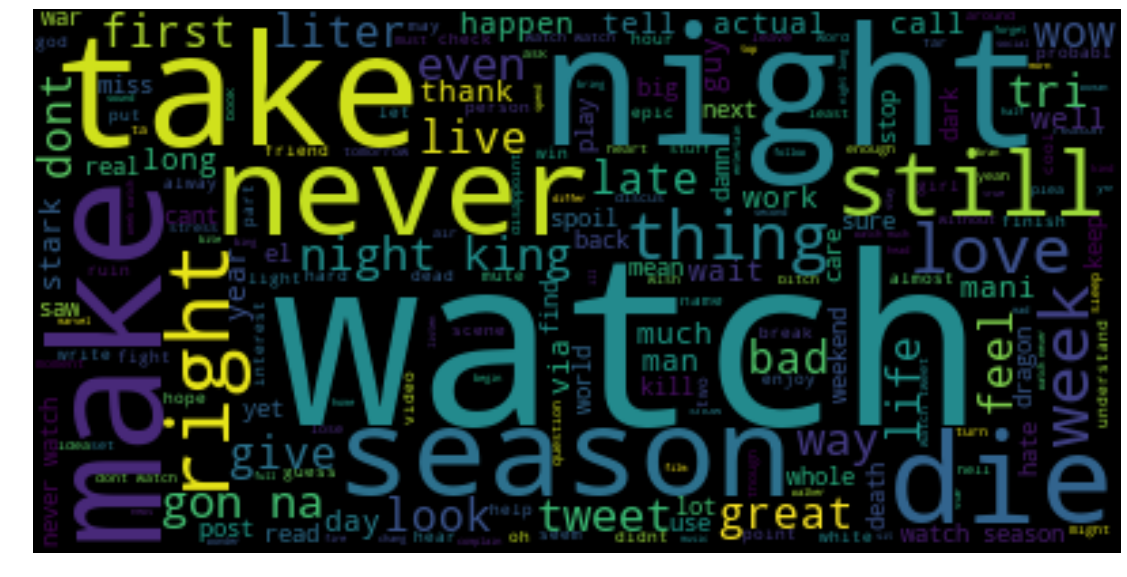

In [75]:
text = long_knight(x)
plt.figure(figsize=(20, 10))
# Create and generate a word cloud image:
stopwords = set(STOPWORDS)
stopwords.update(['throne', 'game', 'go', 'final', 'twitter', 'tonight', 'think', 'time', 'show', 'good', 'end', 'new', 'come',
             'fan', 'start', 'know', 'one', 'say', 'spoiler', 'best', 'need', 'want', 'talk', 'see', 'today', 'last', 'catch'])

wc = WordCloud(stopwords=stopwords, contour_width=2, background_color='black')
wc.generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### The Last of Starks

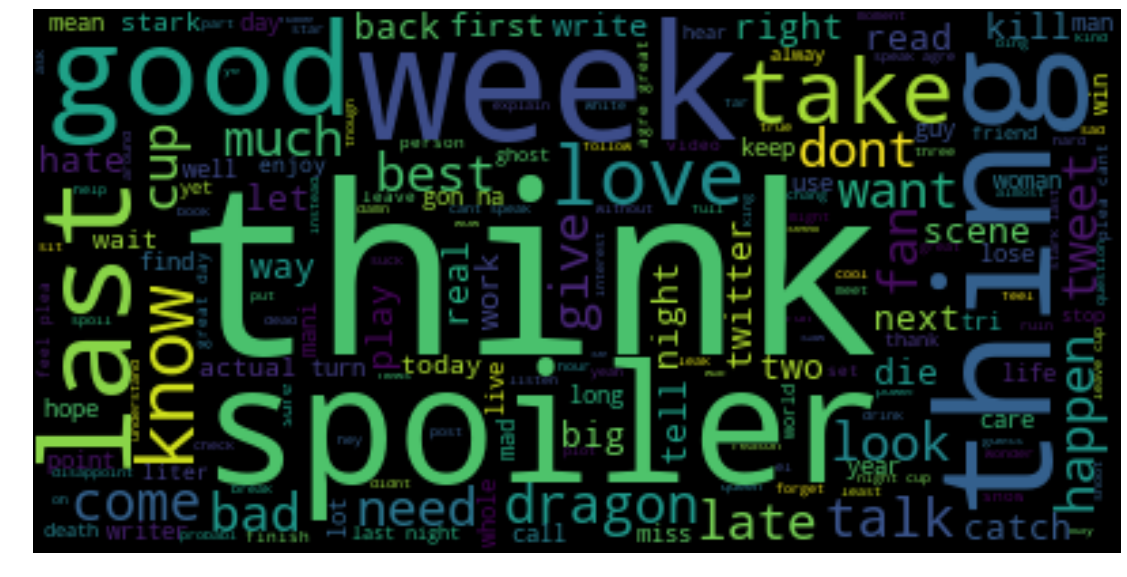

In [76]:
text = last_of_starks(x)
plt.figure(figsize=(20, 10))
# Create and generate a word cloud image:
stopwords = set(STOPWORDS)
stopwords.update(['throne', 'game', 'go', 'final', 'tonight', 'time', 'season', 'see', 'say', 'start', 'watch', 'via','make',
             'show','new', 'anyone', 'really', 'still', 'anyone', 'already', 'anything', 'never', 'everyone', 'even', 'one', 'end'])

wc = WordCloud(stopwords=stopwords, contour_width=2, background_color='black')
wc.generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### The Bells

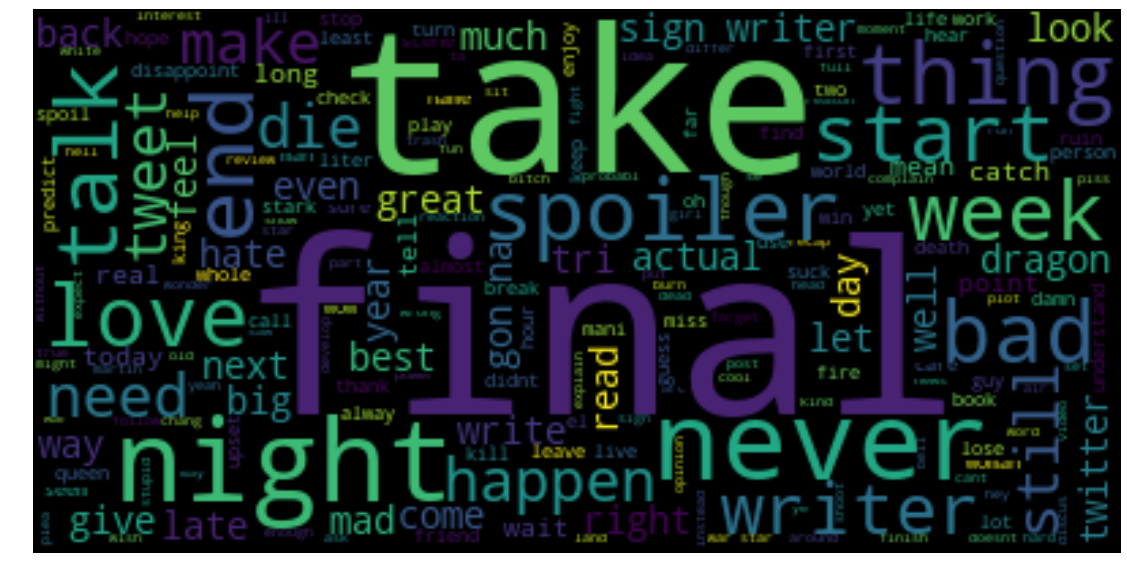

In [77]:
text = the_bells(x)
plt.figure(figsize=(20, 10))
# Create and generate a word cloud image:
stopwords = set(STOPWORDS)
stopwords.update(['throne', 'game', 'new', 'petit', 'via', 'one', 'season', 'fan', 'time', 'theory', 'last',
             'see', 'tonight', 'good', 'think', 'say', 'want', 'show', 'know', 'watch', 'go', 'dont'])

wc = WordCloud(stopwords=stopwords, contour_width=2, background_color='black')
wc.generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### The Iron Throne

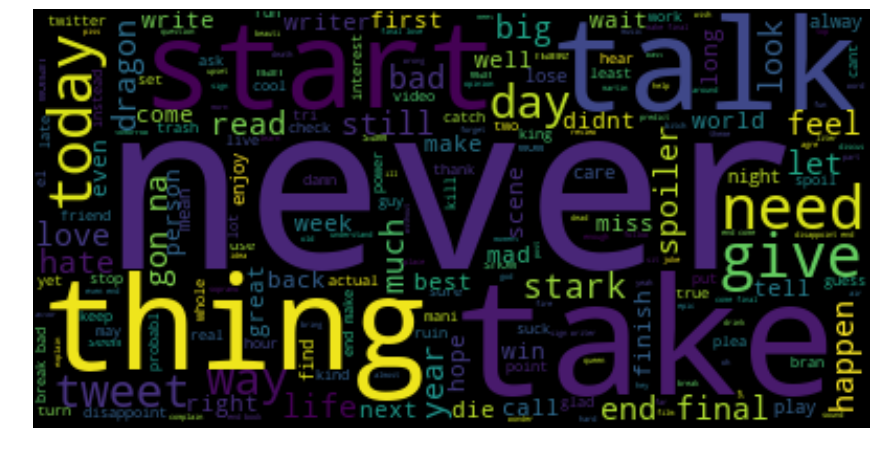

In [78]:
text = iron_throne(x)
plt.figure(figsize=(15, 15))
# Create and generate a word cloud image:
stopwords = set(STOPWORDS)
stopwords.update(['throne', 'game', 'new', 'petit', 'via', 'one', 'season', 'fan', 'time', 'theory', 'last',
             'see', 'tonight', 'good', 'think', 'say', 'want', 'show', 'know', 'watch', 'go', 'dont'])

wc = WordCloud(stopwords=stopwords, contour_width=2, background_color='black')
wc.generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Conclusion

* The Initial episodes had a positive reaction. This may be due to the year long gap between Season 7 & Season 8.
* The negative sentiment grows after the initial episodes.
* Most negative sentiment observed for Episode 5 - 'The Bells'.